## **Deep Q-Network (DQN)**
Pavlos Ntais - 1115202100122

### **Import Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
import numpy as np
import sys
import collections
import random
from typing import Dict, List, Tuple
from matplotlib import pyplot as plt

In [2]:
class Q_net(nn.Module):
    def __init__(self, state_space=None, action_space=None, hidden_space=128):
        super(Q_net, self).__init__()

        self.action_space = action_space
        self.hidden_space = hidden_space
        self.state_space  = state_space
        self.layer1       = nn.Linear(self.state_space, self.hidden_space)
        self.lstm         = nn.LSTM(self.hidden_space,self.hidden_space, batch_first=True)
        self.layer2       = nn.Linear(self.hidden_space, self.action_space)

    def forward(self, x, h, c):
        x                 = F.relu(self.layer1(x))
        x, (new_h, new_c) = self.lstm(x,(h,c))
        x                 = self.layer2(x)
        return x, new_h, new_c

    def sample_action(self, observation, h,c, epsilon):
        output = self.forward(observation, h,c)

        if random.random() < epsilon: return random.randint(0,1), output[1], output[2]
        else:                         return output[0].argmax().item(), output[1] , output[2]
    
    def init_hidden_state(self, batch_size, training=None):
        if training:
            return torch.zeros([1, batch_size, self.hidden_space]), torch.zeros([1, batch_size, self.hidden_space])
        else:
            return torch.zeros([1, 1, self.hidden_space]), torch.zeros([1, 1, self.hidden_space])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
class EpisodeMemory():
    def __init__(self, random_update=False, max_epi_num=100, max_epi_len=200, batch_size=1, lookup_step=None):
        self.random_update = random_update
        self.max_epi_num   = max_epi_num
        self.max_epi_len   = max_epi_len
        self.batch_size    = batch_size
        self.lookup_step   = lookup_step
        self.memory        = collections.deque(maxlen=self.max_epi_num)

    def put(self, episode):
        self.memory.append(episode)

    def sample(self):
        sampled_buffer = list()

        # random update
        if self.random_update:
            sampled_episodes = random.sample(self.memory, self.batch_size)
            min_step         = self.max_epi_len

            for episode in sampled_episodes:
                min_step = min(min_step, len(episode))

            for episode in sampled_episodes:
                if min_step > self.lookup_step:
                    idx    = np.random.randint(0, len(episode)-self.lookup_step+1)
                    sample = episode.sample(random_update=self.random_update, lookup_step=self.lookup_step, idx=idx)
                    sampled_buffer.append(sample)
                else:
                    idx    = np.random.randint(0, len(episode)-min_step+1)
                    sample = episode.sample(random_update=self.random_update, lookup_step=min_step, idx=idx)
                    sampled_buffer.append(sample)

        # sequential update
        else:
            idx = np.random.randint(0, len(self.memory))
            sampled_buffer.append(self.memory[idx].sample(random_update=self.random_update))

        return sampled_buffer, len(sampled_buffer[0]['observation'])

    def __len__(self):
        return len(self.memory)

class EpisodeBuffer:
    def __init__(self):
        self.observation = list()
        self.action      = list()
        self.reward      = list()
        self.next_obs    = list()
        self.done        = list()

    def put(self, transition):
        self.observation.append(transition[0])
        self.action.append(transition[1])
        self.reward.append(transition[2])
        self.next_obs.append(transition[3])
        self.done.append(transition[4])

    def sample(self, random_update=False, lookup_step=None, idx=None) -> Dict[str, np.ndarray]:
        observation = np.array(self.observation)
        action      = np.array(self.action)
        reward      = np.array(self.reward)
        next_obs    = np.array(self.next_obs)
        done        = np.array(self.done)

        if random_update is True:
            observation = observation[idx:idx+lookup_step]
            action      = action[idx:idx+lookup_step]
            reward      = reward[idx:idx+lookup_step]
            next_obs    = next_obs[idx:idx+lookup_step]
            done        = done[idx:idx+lookup_step]

        return dict(observation=observation, acts=action, rews=reward, next_obs=next_obs, done=done)

    def __len__(self) -> int:
        return len(self.observation)

In [4]:
print_per_iter = 10

def compute_rolling_average(rewards, window_size=print_per_iter):
    """
    Computes the rolling average of rewards.

    Args:
        rewards (list): List of rewards per episode.
        window_size (int): Number of episodes to average over.

    Returns:
        list: Rolling average rewards.
    """
    
    return [
        np.mean(rewards[max(0, i - window_size + 1):i + 1])
        for i in range(len(rewards))
    ]

def plot_rewards(results, param_name, window_size=print_per_iter):
    """
    Plots the average rewards (rolling average) for each tested value of a hyperparameter.

    Args:
        results (list): List of dictionaries containing 'value' and 'rewards'.
        param_name (str): Name of the hyperparameter being tested.
        window_size (int): Number of episodes for rolling average.
    """
    
    plt.figure(figsize=(12, 6))

    if (param_name == "eps_start"):       param_n = "epsilon start"
    elif (param_name == "batch_size"):    param_n = "batch size"
    elif (param_name == "learning_rate"): param_n = "learning rate"
    else:                                 param_n = "target update frequency"
     
    for result in results:
        value       = result["value"]
        rewards     = result["rewards"]
        avg_rewards = compute_rolling_average(rewards, window_size=window_size)

        plt.plot(avg_rewards, label=f"{param_n}={value}")

    plt.title(f"Average rewards for values of {param_n}")
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid()
    plt.show()

def plot_single_reward(rewards, title, window_size=print_per_iter):
    """
    Plots the average rewards (rolling average) for a single run.

    Args:
        rewards (list): List of rewards for each episode.
        title (str): Title of the graph.
        window_size (int): Number of episodes for rolling average.
    """
    
    avg_rewards = compute_rolling_average(rewards, window_size=window_size)
    
    plt.figure(figsize=(12, 6))
    plt.plot(avg_rewards)
    
    plt.title(title)
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
def get_observation_fully_observable(state):
    # state is fully observable
    return state

def get_observation_pomdp(state):
    # POMDP: only position is observable
    return np.array([state[0]])

def get_observation_noisy_pomdp(state, noise_std=0.01):
    noise = np.random.normal(0, noise_std)
    observable_state = state[0] + noise
    return np.array([observable_state])

### **Train routines**

In [6]:
def convert_data(data, batch_size, seq_len, device):
    data = np.array(data)
    return torch.FloatTensor(data.reshape(batch_size, seq_len, -1)).to(device)

def train(q_net=None, target_q_net=None, episode_memory=None, device=None, optimizer = None, batch_size=1, learning_rate=1e-4, gamma=0.99):
    samples, seq_len = episode_memory.sample()

    observations      = list()
    actions           = list()
    rewards           = list()
    dones             = list()
    next_observations = list()
    
    for i in range(batch_size):
        observations.append(samples[i]["observation"])
        actions.append(samples[i]["acts"])
        rewards.append(samples[i]["rews"])
        next_observations.append(samples[i]["next_obs"])
        dones.append(samples[i]["done"])

    # get data
    observations      = convert_data(observations, batch_size, seq_len, device)
    rewards           = convert_data(rewards, batch_size, seq_len, device)
    next_observations = convert_data(next_observations, batch_size, seq_len, device)
    dones             = convert_data(dones, batch_size, seq_len, device)
    actions           = np.array(actions)
    actions           = torch.LongTensor(actions.reshape(batch_size,seq_len,-1)).to(device)

    # get action, reward
    h_target, c_target = target_q_net.init_hidden_state(batch_size=batch_size, training=True)
    q_target, _, _     = target_q_net(next_observations, h_target.to(device), c_target.to(device))
    next_q_values      = q_target.max(2)[0].view(batch_size, seq_len,-1).detach()
    target_q_values    = rewards + gamma*next_q_values * dones

    h, c        = q_net.init_hidden_state(batch_size=batch_size, training=True)
    q_out, _, _ = q_net(observations, h.to(device), c.to(device))

    # calculate loss
    loss = F.smooth_l1_loss(q_out.gather(2, actions), target_q_values)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def train_drqn(observation_function, verbose=False):
    global epsilon
    
    
    rewards = list()

    for episode in range(num_episodes):
        curr_state     = env.reset()
        observation    = observation_function(curr_state)
        
        done           = False
        episode_reward = 0

        # initialize episode buffer
        episode_record = EpisodeBuffer()
        h, c = policy_net.init_hidden_state(batch_size=batch_size, training=False)

        for t in range(max_step):
            action, h, c = policy_net.sample_action(
                torch.from_numpy(observation).float().to(device).unsqueeze(0).unsqueeze(0), 
                h.to(device), c.to(device), epsilon
            )

            # perform action
            new_state, reward, done, _ = env.step(action)
            new_observation = observation_function(new_state)
            is_done         = 0.0 if done else 1.0

            episode_record.put([observation, action, reward / 100.0, new_observation, is_done])
            observation     = new_observation
            episode_reward += reward

            if len(episode_memory) >= min_epi_num:
                train(policy_net, target_net, episode_memory, device, optimizer, batch_size, learning_rate)

                if (t + 1) % target_update_frequency == 0:
                    for param_targ, param_local in zip(target_net.parameters(), policy_net.parameters()):
                        param_targ.data.copy_(tau * param_local.data + (1.0 - tau) * param_targ.data)

            if done: break

        # decay epsilon
        epsilon = max(eps_end, epsilon * eps_decay)

        # record the episode
        episode_memory.put(episode_record)

        rewards.append(episode_reward)

        # print results
        if verbose and episode % print_per_iter == 0 and episode != 0:
            avg_reward = np.mean(rewards[-print_per_iter:])
            print(f"Episode {episode}, Reward: {avg_reward:.2f}, Epsilon: {epsilon:.2f}")
    
    return rewards

### **Hyperparameters**

In [7]:
# train hyperparameters
batch_size              = 32
learning_rate           = 1e-3
buffer_len              = 100000
min_epi_num             = 32
num_episodes            = 930
target_update_frequency = 10
eps_start               = 0.5
eps_end                 = 0.01
eps_decay               = 0.995
tau                     = 0.05
max_step                = 200
seed_n                  = 42
num_layers              = 128

# DRQN Hyperparameters
random_update = True
lookup_step   = 30
max_epi_num_n = 100
max_epi_len_n = 200

In [8]:
def set_rand(seed=seed_n):
    np.random.seed(seed)
    random.seed(seed)
    env.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark     = False
        torch.backends.cudnn.deterministic = True

In [9]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get environment
env = gym.make("MountainCar-v0")

output_dim = env.action_space.n

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### **Fully Observable Environment**

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 10, Reward: -200.00, Epsilon: 0.47
Episode 20, Reward: -200.00, Epsilon: 0.45
Episode 30, Reward: -200.00, Epsilon: 0.43
Episode 40, Reward: -200.00, Epsilon: 0.41
Episode 50, Reward: -200.00, Epsilon: 0.39
Episode 60, Reward: -200.00, Epsilon: 0.37
Episode 70, Reward: -200.00, Epsilon: 0.35
Episode 80, Reward: -200.00, Epsilon: 0.33
Episode 90, Reward: -200.00, Epsilon: 0.32
Episode 100, Reward: -200.00, Epsilon: 0.30
Episode 110, Reward: -200.00, Epsilon: 0.29
Episode 120, Reward: -200.00, Epsilon: 0.27
Episode 130, Reward: -200.00, Epsilon: 0.26
Episode 140, Reward: -200.00, Epsilon: 0.25
Episode 150, Reward: -200.00, Epsilon: 0.23
Episode 160, Reward: -200.00, Epsilon: 0.22
Episode 170, Reward: -200.00, Epsilon: 0.21
Episode 180, Reward: -200.00, Epsilon: 0.20
Episode 190, Reward: -200.00, Epsilon: 0.19
Episode 200, Reward: -200.00, Epsilon: 0.18
Episode 210, Reward: -200.00, Epsilon: 0.17
Episode 220, Reward: -200.00, Epsilon: 0.17
Episode 230, Reward: -200.00, Epsilon: 0.

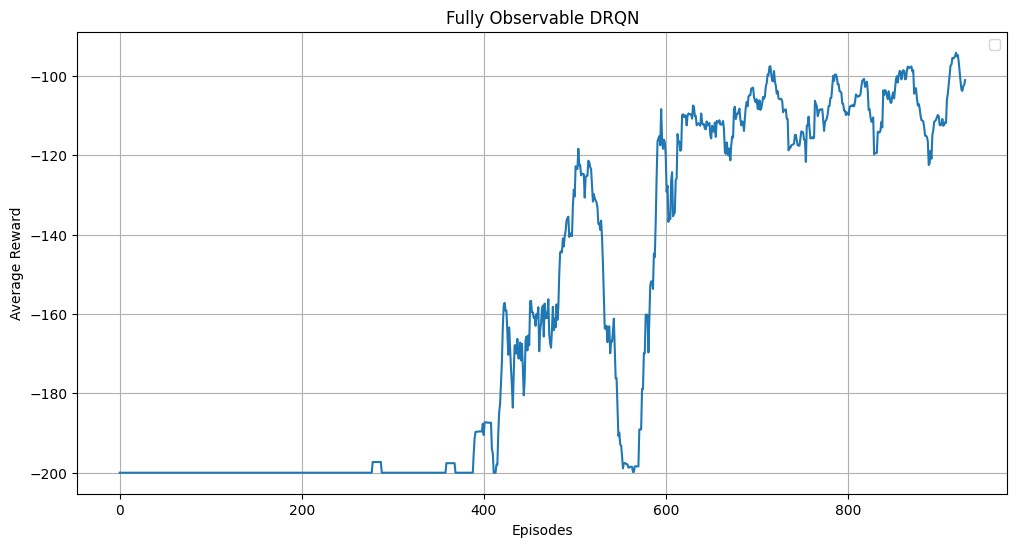

In [10]:
set_rand()

# initialize networks
input_dim  = env.observation_space.shape[0]
policy_net = Q_net(input_dim, output_dim, num_layers).to(device)
target_net = Q_net(input_dim, output_dim, num_layers).to(device)
target_net.load_state_dict(policy_net.state_dict())

# optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

epsilon = eps_start
episode_memory = EpisodeMemory(random_update=random_update, max_epi_num=max_epi_num_n, max_epi_len=max_epi_len_n, 
                               batch_size=batch_size, lookup_step=lookup_step)

fully_obs_rewards = train_drqn(get_observation_fully_observable, True)
plot_single_reward(fully_obs_rewards, "Fully Observable DRQN")

### **Sensitivity Study**

In [11]:
# default hyperparameters
default_hyperparameters = {
    "learning_rate": 1e-3,
    "batch_size": 32,
    "eps_start": 0.5,
    "target_update_frequency": 10,
}

hyperparameter_values = {
    "learning_rate": [1e-3, 3e-4, 7e-3, 1e-4],
    "batch_size": [16, 32, 64, 128],
    "eps_start": [0.90, 0.70, 0.50, 0.30],
    "target_update_frequency": [5, 10, 20, 35],
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
def set_hyperparameters(lr, b_size, eps_start_v, tupdate_freq):
    global episode_memory, optimizer, policy_net, target_net
    global learning_rate, batch_size, eps_start, min_epi_num, target_update_frequency, epsilon

    set_rand()

    # set hyperparameters
    learning_rate           = lr
    batch_size              = b_size
    min_epi_num             = batch_size
    eps_start               = eps_start_v
    epsilon                 = eps_start
    target_update_frequency = tupdate_freq

    policy_net = Q_net(input_dim, output_dim, num_layers).to(device)
    target_net = Q_net(input_dim, output_dim, num_layers).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    
    # optimizer
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    
    episode_memory = EpisodeMemory(random_update=random_update, max_epi_num=max_epi_num_n,
                      max_epi_len=max_epi_len_n, batch_size=batch_size, lookup_step=lookup_step)

def run_experiment(lr, b_size, eps_start_v, tupdate_freq):
    set_rand()
    set_hyperparameters(lr, b_size, eps_start_v, tupdate_freq)

    print(f"Set hyperparameters: Learning Rate={learning_rate}, Batch Size={batch_size}, Epsilon start={eps_start}, Target Update Frequency={target_update_frequency}")
    
    return train_drqn(get_observation_fully_observable)

def hyperparameter_test(default_rewards=None):
    for param, values in hyperparameter_values.items():
        print(f"Testing hyperparameter: {param}")
        param_results = list()
        
        b_size      = default_hyperparameters["batch_size"]
        eps_start_v = default_hyperparameters["eps_start"]
        tuf         = default_hyperparameters["target_update_frequency"]
        lr          = default_hyperparameters["learning_rate"]
    
        for value in values:
            # set hyperparameters
            if param == "learning_rate": lr          = value
            elif param == "batch_size":  b_size      = value
            elif param == "eps_start":   eps_start_v = value
            else:                        tuf         = value

            if lr == default_hyperparameters["learning_rate"] and b_size == default_hyperparameters["batch_size"] and eps_start_v == default_hyperparameters["eps_start"] and tuf == default_hyperparameters["target_update_frequency"]:
                param_results.append({
                    "value": value,
                    "rewards": default_rewards
                })
                continue
            
            rewards = run_experiment(lr, b_size, eps_start_v, tuf)
            param_results.append({
                "value": value,
                "rewards": rewards
            })
        plot_rewards(param_results, param, window_size=print_per_iter)

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Testing hyperparameter: learning_rate
Set hyperparameters: Learning Rate=0.0003, Batch Size=32, Epsilon start=0.5, Target Update Frequency=10
Set hyperparameters: Learning Rate=0.007, Batch Size=32, Epsilon start=0.5, Target Update Frequency=10
Set hyperparameters: Learning Rate=0.0001, Batch Size=32, Epsilon start=0.5, Target Update Frequency=10


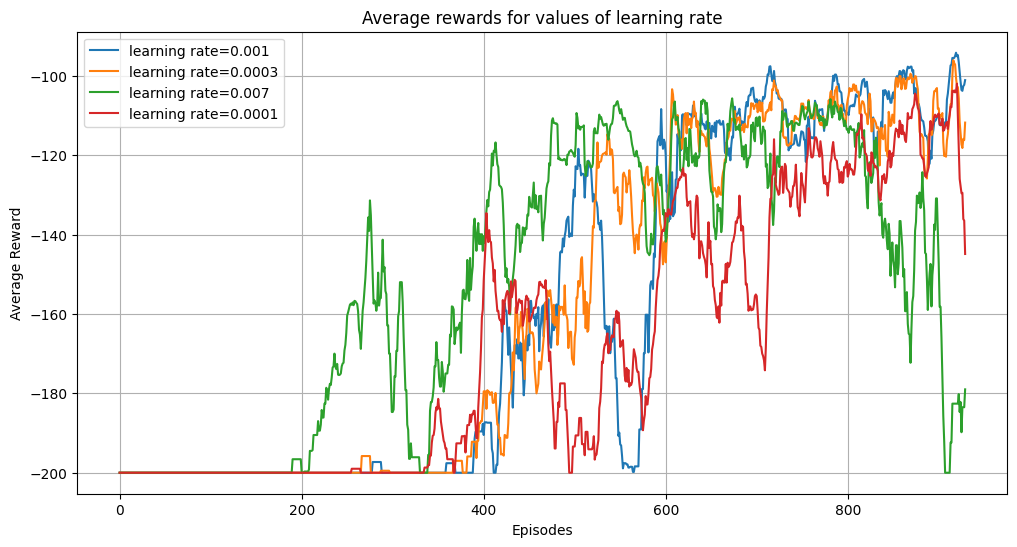

Testing hyperparameter: batch_size
Set hyperparameters: Learning Rate=0.001, Batch Size=16, Epsilon start=0.5, Target Update Frequency=10
Set hyperparameters: Learning Rate=0.001, Batch Size=64, Epsilon start=0.5, Target Update Frequency=10
Set hyperparameters: Learning Rate=0.001, Batch Size=128, Epsilon start=0.5, Target Update Frequency=10


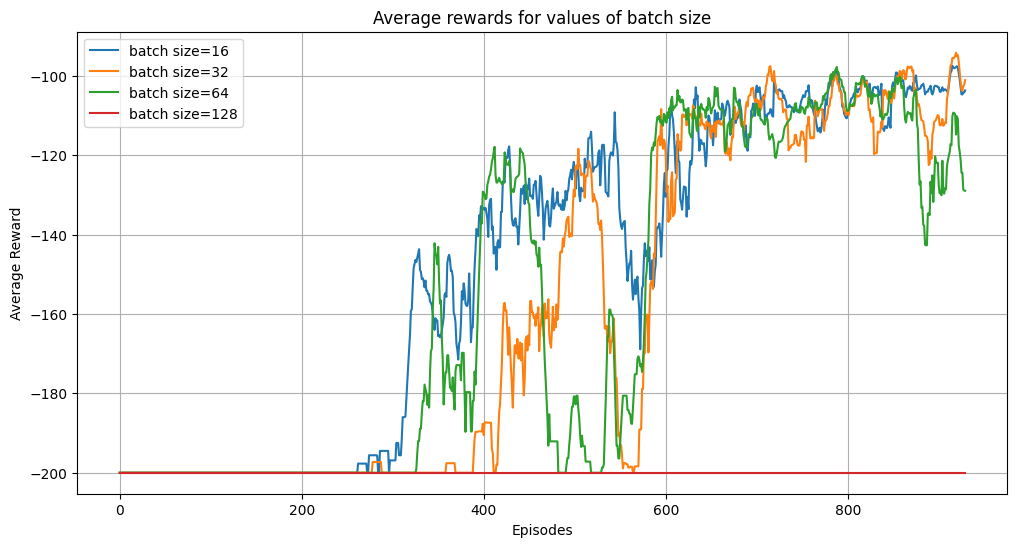

Testing hyperparameter: eps_start
Set hyperparameters: Learning Rate=0.001, Batch Size=32, Epsilon start=0.9, Target Update Frequency=10
Set hyperparameters: Learning Rate=0.001, Batch Size=32, Epsilon start=0.7, Target Update Frequency=10
Set hyperparameters: Learning Rate=0.001, Batch Size=32, Epsilon start=0.3, Target Update Frequency=10


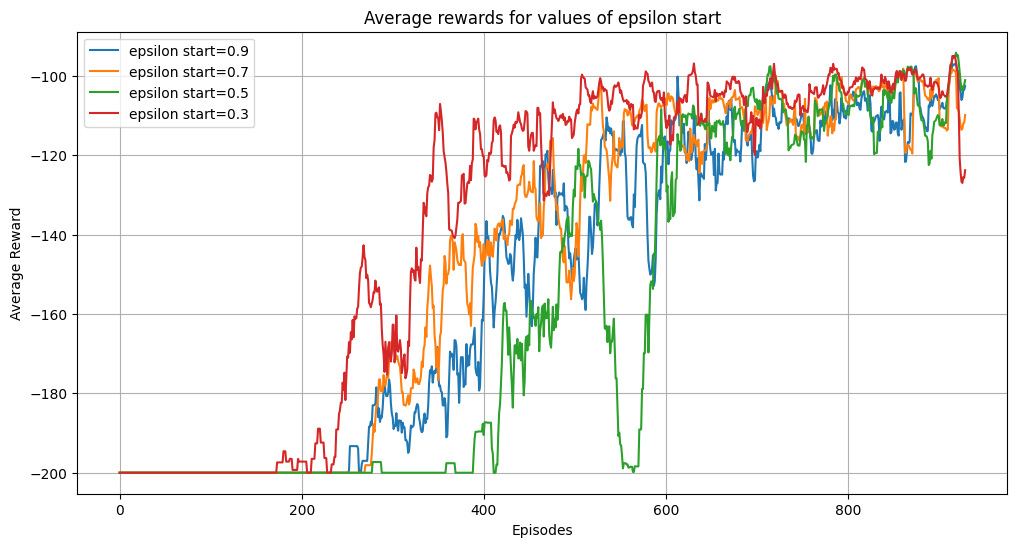

Testing hyperparameter: target_update_frequency
Set hyperparameters: Learning Rate=0.001, Batch Size=32, Epsilon start=0.5, Target Update Frequency=5
Set hyperparameters: Learning Rate=0.001, Batch Size=32, Epsilon start=0.5, Target Update Frequency=20
Set hyperparameters: Learning Rate=0.001, Batch Size=32, Epsilon start=0.5, Target Update Frequency=35


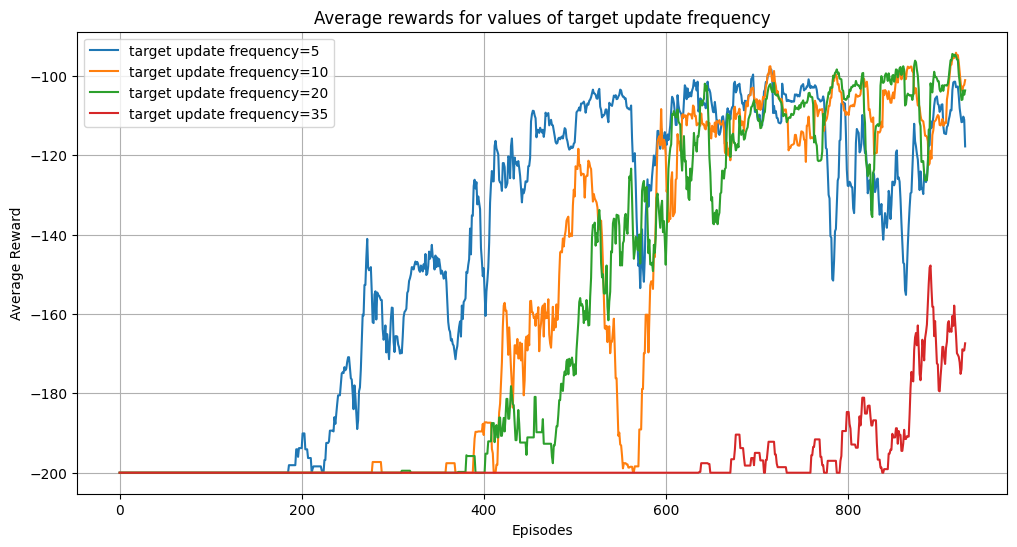

In [13]:
hyperparameter_test(fully_obs_rewards)

### **Partially Observable Environment**

Episode 10, Reward: -200.00, Epsilon: 0.47
Episode 20, Reward: -200.00, Epsilon: 0.45
Episode 30, Reward: -200.00, Epsilon: 0.43
Episode 40, Reward: -200.00, Epsilon: 0.41
Episode 50, Reward: -200.00, Epsilon: 0.39
Episode 60, Reward: -200.00, Epsilon: 0.37
Episode 70, Reward: -200.00, Epsilon: 0.35
Episode 80, Reward: -200.00, Epsilon: 0.33
Episode 90, Reward: -200.00, Epsilon: 0.32
Episode 100, Reward: -200.00, Epsilon: 0.30
Episode 110, Reward: -200.00, Epsilon: 0.29
Episode 120, Reward: -200.00, Epsilon: 0.27
Episode 130, Reward: -200.00, Epsilon: 0.26
Episode 140, Reward: -200.00, Epsilon: 0.25
Episode 150, Reward: -200.00, Epsilon: 0.23
Episode 160, Reward: -200.00, Epsilon: 0.22
Episode 170, Reward: -200.00, Epsilon: 0.21
Episode 180, Reward: -200.00, Epsilon: 0.20
Episode 190, Reward: -200.00, Epsilon: 0.19
Episode 200, Reward: -200.00, Epsilon: 0.18
Episode 210, Reward: -200.00, Epsilon: 0.17
Episode 220, Reward: -200.00, Epsilon: 0.17
Episode 230, Reward: -200.00, Epsilon: 0.

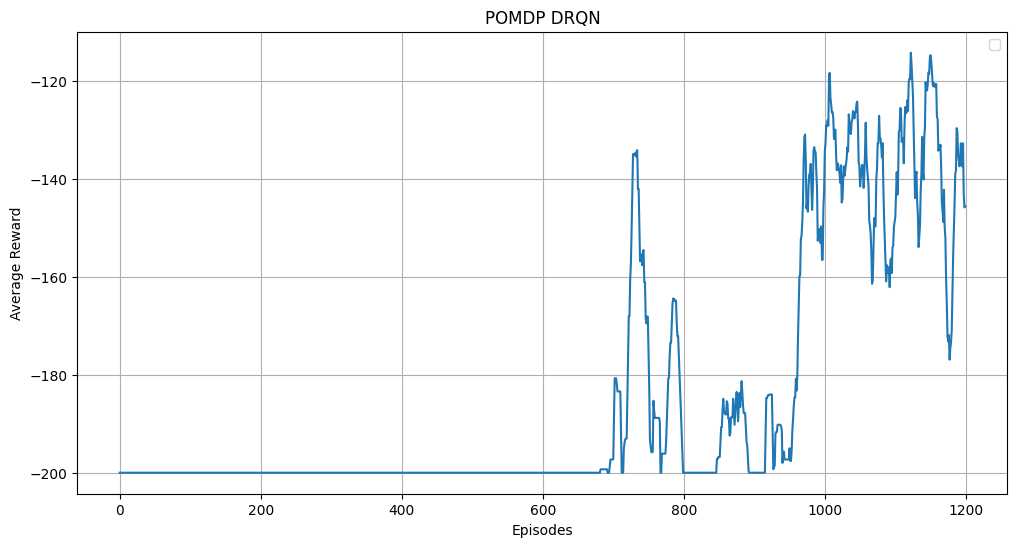

In [14]:
set_rand()

num_episodes            = 1200
batch_size              = 32
eps_start               = 0.5
target_update_frequency = 10
learning_rate           = 1e-4

# initialize networks
input_dim  = 1  # only the position is observable
policy_net = Q_net(input_dim, output_dim, num_layers).to(device)
target_net = Q_net(input_dim, output_dim, num_layers).to(device)
target_net.load_state_dict(policy_net.state_dict())

# optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

epsilon = eps_start
episode_memory = EpisodeMemory(random_update=random_update, max_epi_num=max_epi_num_n, max_epi_len=max_epi_len_n, 
                               batch_size=batch_size, lookup_step=lookup_step)

rewards = train_drqn(get_observation_pomdp, True)
plot_single_reward(rewards, "POMDP DRQN")

### **Noisy Partially Observable Environment**

Episode 10, Reward: -200.00, Epsilon: 0.47
Episode 20, Reward: -200.00, Epsilon: 0.45
Episode 30, Reward: -200.00, Epsilon: 0.43
Episode 40, Reward: -200.00, Epsilon: 0.41
Episode 50, Reward: -200.00, Epsilon: 0.39
Episode 60, Reward: -200.00, Epsilon: 0.37
Episode 70, Reward: -200.00, Epsilon: 0.35
Episode 80, Reward: -200.00, Epsilon: 0.33
Episode 90, Reward: -200.00, Epsilon: 0.32
Episode 100, Reward: -200.00, Epsilon: 0.30
Episode 110, Reward: -200.00, Epsilon: 0.29
Episode 120, Reward: -200.00, Epsilon: 0.27
Episode 130, Reward: -200.00, Epsilon: 0.26
Episode 140, Reward: -200.00, Epsilon: 0.25
Episode 150, Reward: -200.00, Epsilon: 0.23
Episode 160, Reward: -200.00, Epsilon: 0.22
Episode 170, Reward: -200.00, Epsilon: 0.21
Episode 180, Reward: -200.00, Epsilon: 0.20
Episode 190, Reward: -200.00, Epsilon: 0.19
Episode 200, Reward: -200.00, Epsilon: 0.18
Episode 210, Reward: -200.00, Epsilon: 0.17
Episode 220, Reward: -200.00, Epsilon: 0.17
Episode 230, Reward: -200.00, Epsilon: 0.

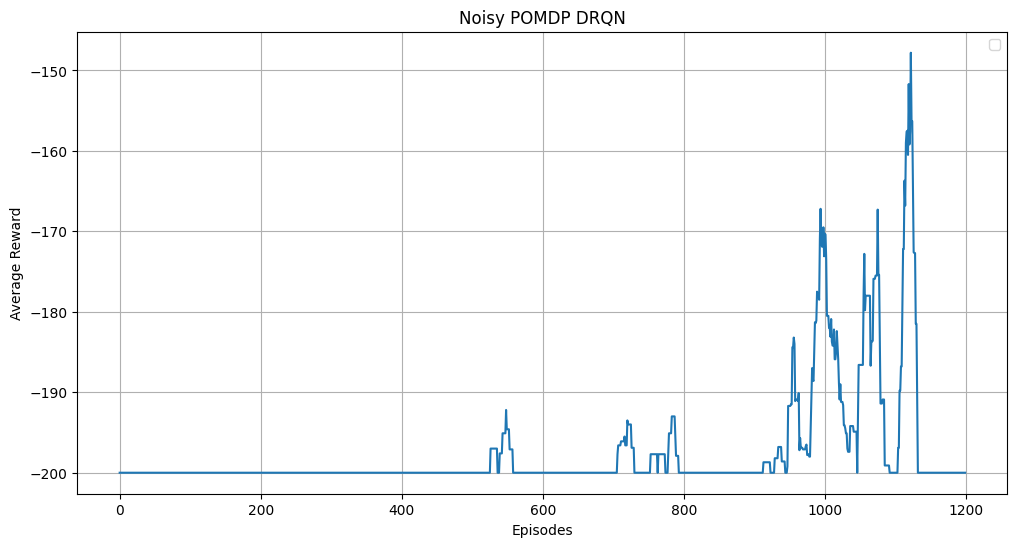

In [15]:
set_rand()

num_episodes            = 1200
batch_size              = 32
eps_start               = 0.5
target_update_frequency = 10
learning_rate           = 1e-4

# initialize networks
input_dim  = 1  # only the position is observable
policy_net = Q_net(input_dim, output_dim, num_layers).to(device)
target_net = Q_net(input_dim, output_dim, num_layers).to(device)
target_net.load_state_dict(policy_net.state_dict())

# optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

epsilon = eps_start
episode_memory = EpisodeMemory(random_update=random_update, max_epi_num=max_epi_num_n, max_epi_len=max_epi_len_n, 
                               batch_size=batch_size, lookup_step=lookup_step)

rewards = train_drqn(get_observation_noisy_pomdp, True)
plot_single_reward(rewards, "Noisy POMDP DRQN")